### Imports and directories

In [1]:
import numpy as np
import os
from oe_acute import trial_utils as tu
from oe_acute import MNE2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import tqdm
import glob
from scipy.ndimage import gaussian_filter1d
from scipy.stats.stats import pearsonr 
import sys
import seaborn as sns

### Change MNE path here!

In [2]:
###details about the dataset folders
bird = 'B1238'
d = 256
exp_path = '/mnt/cube/lstanwic/reducted_data/s_b1238_22/' 
radius = 10 
output_file_mne_pfinal = os.path.join(exp_path, 'MNE_pfinal_res_b1238_20220127.pkl')

### Load data

In [3]:

# contains stim spectrograms and response class matrices
with open(output_file_mne_pfinal, 'rb') as f:
    results_dict_pfinal = pickle.load(f)

n_cells = len(results_dict_pfinal['units'])

# pfinals
# this is by class
mne_results = results_dict_pfinal['results']
print(len(mne_results))

# spectrograms and responses
stim_spectrograms = results_dict_pfinal['stim_spectrograms']
response_classes = results_dict_pfinal['stim_response_classes']
avg_nrows = results_dict_pfinal['n_rows_avg']
avg_ncols = results_dict_pfinal['n_cols_avg']
nsegbins = results_dict_pfinal['nsegbins']
stim_resp = results_dict_pfinal['stim_resp']
n_cells = len(results_dict_pfinal['units'])

2


In [5]:
#response_classes = [stim_responses, fs_stim_responses, ms_stim_responses, ps_stim_responses]
pfinals = mne_results[0]
pfinals_full_shuff = mne_results[1]
# pfinals_mask_shuff = mne_results[2]
# pfinals_permute_shuff = mne_results[3]
units_to_process = results_dict_pfinal['units']
stims_train, resps_train, stims_test, resps_test = stim_resp[0]
stims_train_full_shuff, resps_train_full_shuff, stims_test_full_shuff, resps_test_full_shuff = stim_resp[1]
# stims_train_mask_shuff, resps_train_mask_shuff, stims_test_mask_shuff, resps_test_mask_shuff = stim_resp[2]
# stims_train_ps_shuff, resps_train_ps_shuff, stims_test_ps_shuff, resps_test_ps_shuff = stim_resp[3]

### Functions

In [6]:
###this function will compute a response with n_trails from the estimated spike probabilities and stim test
def predict_spiking_response(pfinal, stim_segs, sdim, n_trials=20):

    '''
    Given a pfinal parameter vector and stimulus segments, predict n_trials spike trains
    stim_segs is an array nsegs x ndim
    spikes is a binary array n_trials x nsegs
    TODO: Specify first order or second order model
    '''

    a = pfinal[0]
    h = pfinal[1:sdim+1]
    J = np.reshape(pfinal[-1*sdim**2:], (sdim, sdim))

    x = a + np.dot(stim_segs, h) + np.sum(stim_segs * (stim_segs.dot(J)), 1)
    probs = 1.0 / (1.0 + np.exp(x))
    spikes = np.less(np.random.rand(n_trials, len(probs)), probs).astype(int)
    return spikes



In [7]:
###this function will estimate spike probabilities from stim test
def predict_spiking_probability(pfinal, stim_segs, sdim, **kwargs):

    '''
    Given a pfinal parameter vector and stimulus segments, predict spiking probabilities
    stim_segs is an array nsegs x ndim
    spikes is a binary array n_trials x nsegs
    '''

    a = pfinal[0]
    h = pfinal[1:sdim+1]
    J = np.reshape(pfinal[-1*sdim**2:], (sdim, sdim))
    x = a + np.dot(stim_segs, h) + np.sum(stim_segs * (stim_segs.dot(J)), 1)
    probs = 1.0 / (1.0 + np.exp(x))
    return probs

###same code as before but fo rlinear model (without the second-order J matrix)
def predict_spiking_prob_lin(pfinal, stim_segs, sdim, **kwargs):

    '''
    Given a pfinal parameter vector and stimulus segments, predict spiking probabilities
    stim_segs is an array nsegs x ndim
    spikes is a binary array n_trials x nsegs
    '''

    a = pfinal[0]
    h = pfinal[1:sdim+1]
    x = a + np.dot(stim_segs, h)
    probs = 1.0 / (1.0 + np.exp(x))
    return probs

In [8]:
###this will compute correlation between MNE estimated spike probabilities and the empirical repsonse i.e. resp test
def evaluate_prediction(pfinal, stims_test, resps_test, sdim, **kwargs):
    '''
    Given a vector of MNE parameters pfinal, predict spiking probabilities using stims_test and the 
    MNE model, and compare these to the given 'resps_test' using pearson correlation
    '''
    resps_test_avg = np.mean(resps_test, axis=1, dtype=np.float)
    probs = predict_spiking_probability(pfinal, stims_test, sdim, **kwargs)
    corr = pearsonr(probs, resps_test_avg.flatten())
    return probs, corr


###again similar code as above but for linear model
def evaluate_pred_lin(pfinal, stims_test, resps_test, sdim, **kwargs):
    '''
    Given a vector of MNE parameters pfinal, predict spiking probabilities using stims_test and the 
    MNE model, and compare these to the given 'resps_test' using pearson correlation
    '''
    resps_test_avg = np.mean(resps_test, axis=1, dtype=np.float)
    probs = predict_spiking_prob_lin(pfinal, stims_test, sdim, **kwargs)
    corr = pearsonr(probs, resps_test_avg.flatten())
    return probs, corr


In [9]:
###this will correlate spike trains, use this if you want to correlate estimate spike train (of say 20 trials) that you got 
###from "predict_spike_train" function above and the actual resp_test of 20 trials
###(this is for correlating spike trains instead of spike proabilities)
def correlate_gaussian_spiketrains(sp1, sp2, tau):
    '''
    Compute the correlation of two gaussian smoothed spike trains
    sp1, sp2 are lists of spike times, tau is the gaussian standard deviation
    '''
    diffmtx = sp2[:, np.newaxis] - sp1[np.newaxis, :]
    n1 = len(sp1)
    n2 = len(sp2)

    corr = np.sum(np.exp(-0.5*(diffmtx**2 / (2*tau**2)))*(tau*np.sqrt(np.pi)))
    return corr

### Corrs for all units

In [10]:
##full model
probs_pred = []
probs_pred_lin = []
resps_all = []
units = []
corrs_full = []
corrs_lin = []

for unit in units_to_process:
    pfinal = pfinals[unit]
    probs, corr = evaluate_prediction(pfinal, stims_test, resps_test, sdim=d)
    probs_lin, corr_lin = evaluate_pred_lin(pfinal, stims_test, resps_test, sdim=d)
    #form lists to save
    probs_pred.append(probs)
    probs_pred_lin.append(probs_lin)
    resps_all.append(resps_test)
    # form lists of correlations
    corrs_full.append(corr[0])
    corrs_lin.append(corr_lin[0])
    units.append(unit)

/home/AD/lstanwic/anaconda3/envs/MNE_tf2/lib/python3.9/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


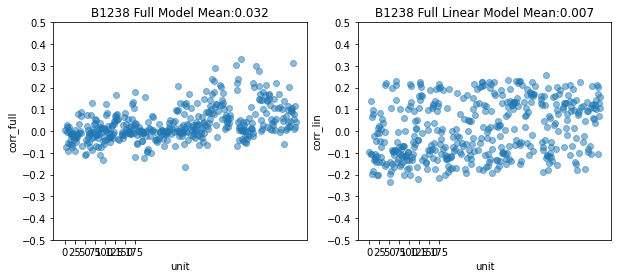

In [11]:
fig, axs = plt.subplots(1,2, figsize = (10,4))
# Plot
axs[0].scatter(units, corrs_full, alpha=0.5)
axs[0].set_title(f"{bird} Full Model Mean:{np.round(np.nanmean(corrs_full),3)}")
axs[0].set_xlabel('unit')
axs[0].set_ylabel('corr_full')
axs[0].set_yticks(np.arange(-0.5,0.52, step=0.1)) 
axs[0].set_xticks(np.arange(0,180, step=25)) 
axs[1].scatter(units, corrs_lin, alpha=0.5)
axs[1].set_title(f"{bird} Full Linear Model Mean:{np.round(np.nanmean(corrs_lin),3)}")
axs[1].set_xlabel('unit')
axs[1].set_ylabel('corr_lin')
axs[1].set_xticks(np.arange(0,180, step=25))
axs[1].set_yticks(np.arange(-0.5,0.52, step=0.1)) 
plt.show()

In [12]:
##full shuffle
probs_pred_fs = []
probs_pred_lin_fs = []
resps_all_fs = []
units_fs = []
corrs_full_fs = []
corrs_lin_fs = []

for unit in units_to_process:
    pfinal = pfinals_full_shuff[unit]
    
    probs, corr = evaluate_prediction(pfinal, stims_test_full_shuff, resps_test_full_shuff, sdim=d)
    probs_lin, corr_lin = evaluate_pred_lin(pfinal, stims_test_full_shuff, resps_test_full_shuff, sdim=d)
    
    #form lists to save
    probs_pred_fs.append(probs)
    probs_pred_lin_fs.append(probs_lin)
    resps_all_fs.append(resps_test_full_shuff)

    # form lists of correlations
    corrs_full_fs.append(corr[0])
    corrs_lin_fs.append(corr_lin[0])
    units_fs.append(unit)

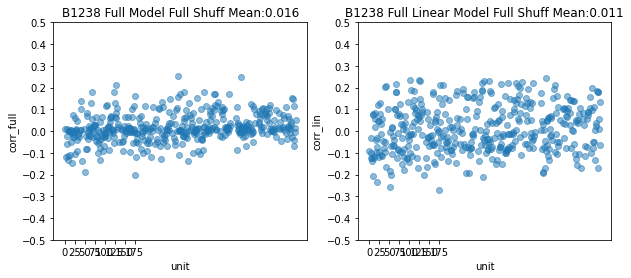

In [14]:
fig, axs = plt.subplots(1,2, figsize = (10,4))
# Plot
axs[0].scatter(units_fs, corrs_full_fs, alpha=0.5)
axs[0].set_title(f"{bird} Full Model Full Shuff Mean:{np.round(np.nanmean(corrs_full_fs),3)}")
axs[0].set_xlabel('unit')
axs[0].set_ylabel('corr_full')
axs[0].set_yticks(np.arange(-0.5,0.52, step=0.1)) 
axs[0].set_xticks(np.arange(0,180, step=25)) 
axs[1].scatter(units, corrs_lin_fs, alpha=0.5)
axs[1].set_title(f"{bird} Full Linear Model Full Shuff Mean:{np.round(np.nanmean(corrs_lin_fs),3)}")
axs[1].set_xlabel('unit')
axs[1].set_ylabel('corr_lin')
axs[1].set_xticks(np.arange(0,180, step=25)) 
axs[1].set_yticks(np.arange(-0.5,0.52, step=0.1)) 
plt.show()

In [ ]:
##mask shuffle
probs_pred_ms = []
probs_pred_lin_ms = []
resps_all_ms = []
units_ms = []
corrs_full_ms = []
corrs_lin_ms = []

for unit in units_to_process:
    pfinal = pfinals_mask_shuff[unit]
    
    probs, corr = evaluate_prediction(pfinal, stims_test_mask_shuff, resps_test_mask_shuff, sdim=d)
    probs_lin, corr_lin = evaluate_pred_lin(pfinal, stims_test_mask_shuff, resps_test_mask_shuff, sdim=d)
    
    #form lists to save
    probs_pred_ms.append(probs)
    probs_pred_lin_ms.append(probs_lin)
    resps_all_ms.append(resps_test_mask_shuff)

    # form lists of correlations
    corrs_full_ms.append(corr[0])
    corrs_lin_ms.append(corr_lin[0])
    units_ms.append(unit)

In [ ]:
#mask shuffle plot

fig, axs = plt.subplots(1,2, figsize = (10,4))
# Plot
axs[0].scatter(units_ms, corrs_full_ms, alpha=0.5)
axs[0].set_title(f"{bird} Full Model Mask Shuff Mean:{np.round(np.nanmean(corrs_full_ms),3)}")
axs[0].set_xlabel('unit')
axs[0].set_ylabel('corr_full')
axs[0].set_yticks(np.arange(-0.5,0.51, step=0.1)) 
axs[0].set_xticks(np.arange(0,180, step=25)) 
axs[1].scatter(units, corrs_lin_ms, alpha=0.5)
axs[1].set_title(f"{bird} Full Linear Model Mask Shuff Mean:{np.round(np.nanmean(corrs_lin_ms),3)}")
axs[1].set_xlabel('unit')
axs[1].set_ylabel('corr_lin')
axs[1].set_xticks(np.arange(0,180, step=25)) 
axs[1].set_yticks(np.arange(-0.5,0.51, step=0.1)) 
plt.show()

In [ ]:
##permute shuffle
probs_pred_ps = []
probs_pred_lin_ps = []
resps_all_ps = []
units_ps = []
corrs_full_ps = []
corrs_lin_ps = []

for unit in units_to_process:
    pfinal = pfinals_permute_shuff[unit]
    
    probs, corr = evaluate_prediction(pfinal, stims_test_ps_shuff, resps_test_ps_shuff, sdim=d)
    probs_lin, corr_lin = evaluate_pred_lin(pfinal, stims_test_ps_shuff, resps_test_ps_shuff, sdim=d)
    
    #form lists to save
    probs_pred_ps.append(probs)
    probs_pred_lin_ps.append(probs_lin)
    resps_all_ps.append(resps_test_ps_shuff)

    # form lists of correlations
    corrs_full_ps.append(corr[0])
    corrs_lin_ps.append(corr_lin[0])
    units_ps.append(unit)

In [ ]:
##perumute shuffle plot
fig, axs = plt.subplots(1,2, figsize = (10,4))
# Plot
axs[0].scatter(units_ps, corrs_full_ps, alpha=0.5)
axs[0].set_title(f"{bird} Full Model Permute Shuff Mean:{np.round(np.nanmean(corrs_full_ps),3)}")
axs[0].set_xlabel('unit')
axs[0].set_ylabel('corr_full')
axs[0].set_yticks(np.arange(-0.5,0.51, step=0.1)) 
axs[0].set_xticks(np.arange(0,180, step=25)) 
axs[1].scatter(units, corrs_lin_ps, alpha=0.5)
axs[1].set_title(f"{bird} Full Linear Model Permute Shuff Mean:{np.round(np.nanmean(corrs_lin_ps),3)}")
axs[1].set_xlabel('unit')
axs[1].set_ylabel('corr_lin')
axs[1].set_xticks(np.arange(0,180, step=25)) 
axs[1].set_yticks(np.arange(-0.5,0.51, step=0.1)) 
plt.show()

In [ ]:
sns.set_style('white')
fig, axes = plt.subplots(2, 2, figsize=(10,6), sharey=True, sharex=True, dpi=100)
sns.histplot(corrs_full , color="orchid", ax=axes[0,0], bins=10, kde=True).set(title=f'Full Model mean: {np.round(np.nanmean(corrs_full),3)}')
sns.histplot(corrs_lin , color="gold", ax=axes[0,1], bins=10, kde=True).set(title=f'Linear Model mean: {np.round(np.nanmean(corrs_lin),3)}')
sns.histplot(corrs_full_fs , color="dodgerblue", ax=axes[1,0], bins=10, kde=True).set(title=f'Full Model Full Shuffle mean: {np.round(np.nanmean(corrs_full_fs),3)}')
sns.histplot(corrs_lin_fs , color="red", ax=axes[1,1], bins=10, kde=True).set(title=f'Linear Model Full Shuffle mean: {np.round(np.nanmean(corrs_lin_fs),3)}')
fig.suptitle(f"{bird}")
fig.tight_layout(pad=2.0);

print(len(corrs_full))
print(len(corrs_full_fs))

In [ ]:
sns.set_style('white')
plt.figure(figsize=(10,7), dpi= 80)
sns.histplot(corrs_full, color="orchid", label="full", bins=10, kde=True)
sns.histplot(corrs_lin, color="gold", label="lin", bins=10, kde=True)
sns.histplot(corrs_full_fs, color="dodgerblue", label="fs full", bins=10, kde=True)
sns.histplot(corrs_lin_fs, color="red", label="fs lin", bins=10, kde=True)
plt.legend();

In [ ]:
sns.set_style('white')
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(corrs_full, color="orchid", label="full", **kwargs)
sns.distplot(corrs_lin, color="gold", label="lin", **kwargs)

plt.legend();

sns.set_style('white')
plt.figure(figsize=(10,7), dpi= 80)
sns.histplot(corrs_full, color="orchid", label="full", kde=True)
sns.histplot(corrs_lin, color="gold", label="lin", kde=True)

plt.legend();

In [ ]:
sns.set_style('white')
fig, axes = plt.subplots(2, 2, figsize=(10,6), sharey=True, sharex=True, dpi=100)
sns.histplot(corrs_full , color="orchid", ax=axes[0,0], bins=10, kde=True).set(title=f'Full Model mean: {np.round(np.nanmean(corrs_full),3)}')
sns.histplot(corrs_full_fs , color="orange", ax=axes[0,1], bins=10, kde=True).set(title=f'Full Shuffle mean: {np.round(np.nanmean(corrs_full_fs),3)}')
sns.histplot(corrs_full_ps , color="green", ax=axes[1,0], bins=10, kde=True).set(title=f'Permute Shuffle mean: {np.round(np.nanmean(corrs_full_ps),3)}')
sns.histplot(corrs_full_ms , color="red", ax=axes[1,1], bins=10, kde=True).set(title=f'Mask Shuffle mean: {np.round(np.nanmean(corrs_full_ms),3)}')
fig.suptitle(f"{bird}")
fig.tight_layout(pad=2.0);


## Corrs for Non-Noise Cells

583
315
[0, 4, 7, 8, 9, 10, 11, 16, 18, 20, 21, 22, 23, 24, 26, 28, 30, 36, 38, 39, 40, 41, 42, 51, 52, 54, 56, 58, 59, 60, 63, 64, 65, 67, 68, 69, 70, 71, 78, 80, 81, 86, 92, 94, 97, 100, 102, 103, 105, 107, 108, 109, 111, 112, 113, 114, 116, 118, 120, 123, 124, 127, 128, 130, 133, 136, 143, 144, 150, 151, 153, 154, 157, 158, 160, 161, 163, 164, 165, 166, 170, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 185, 190, 192, 193, 195, 197, 200, 201, 203, 204, 209, 213, 217, 218, 220, 221, 235, 236, 239, 243, 247, 249, 253, 254, 255, 256, 259, 260, 262, 263, 265, 268, 274, 276, 278, 281, 283, 284, 285, 286, 287, 288, 290, 291, 293, 294, 295, 299, 300, 301, 302, 307, 308, 316, 317, 320, 321, 322, 324, 325, 326, 327, 328, 329, 330, 331, 333, 336, 342, 343, 344, 346, 347, 348, 350, 356, 357, 359, 360, 361, 362, 363, 364, 365, 368, 369, 370, 373, 374, 375, 376, 377, 378, 379, 380, 382, 384, 389, 390, 391, 393, 394, 395, 396, 397, 399, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 4

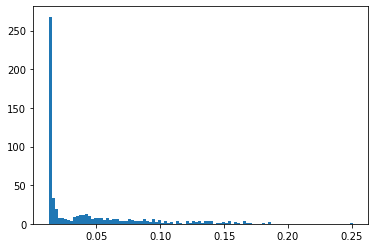

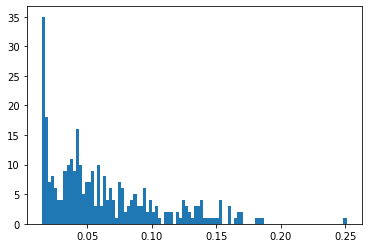

In [15]:
#Pull out sets of cells from histogram after removing the noise cells 
n_dim = d
from numpy.linalg import eigvalsh as brad
#get J matrix for each cell and compute spectral radi
spectra = []
J_np = [np.reshape(x[(n_dim+1):], (n_dim, n_dim)) for x in mne_results[0]]
for J in J_np:
    radium = max(abs(brad(J)))
    spectra.append(radium)
#print(spectra)
fig, ax = plt.subplots(1,1)
bht,bins,x = ax.hist(spectra, bins=100)
print(len(spectra))
spectra_array = np.array(spectra)
spectra_array_thresholded = spectra_array > bins[1]
#print(spectra_array_thresholded)
from itertools import compress
spectra_thresholded_list = list(compress(spectra, spectra_array_thresholded))
print(len(spectra_thresholded_list))
fig, ax = plt.subplots(1,1)
bht,bins,x = ax.hist(spectra_thresholded_list, bins=100)
spectra_chopped_array = np.array(spectra_thresholded_list)
units_to_process_good = list(compress(units_to_process, spectra_array_thresholded))
print(units_to_process_good )

In [16]:
probs_pred_good = []
probs_pred_lin_good = []
resps_all_good = []
units_good = []
corrs_full_good = []
corrs_lin_good = []

for unit in units_to_process_good:
    pfinal = pfinals[unit]
    probs, corr = evaluate_prediction(pfinal, stims_test, resps_test, sdim=d)
    probs_lin, corr_lin = evaluate_pred_lin(pfinal, stims_test, resps_test, sdim=d)
    #form lists to save
    probs_pred_good.append(probs)
    probs_pred_lin_good.append(probs_lin)
    resps_all_good.append(resps_test)
    # form lists of correlations
    corrs_full_good.append(corr[0])
    corrs_lin_good.append(corr_lin[0])
    units_good.append(unit)

In [17]:
def run_corrs(units_to_process, pfinals, stims_test, resps_test):
    probs_pred = []
    probs_pred_lin = []
    resps_all = []
    units = []
    corrs_full = []
    corrs_lin = []

    for unit in units_to_process:
        pfinal = pfinals[unit]
        probs, corr = evaluate_prediction(pfinal, stims_test, resps_test, sdim=d)
        probs_lin, corr_lin = evaluate_pred_lin(pfinal, stims_test, resps_test, sdim=d)
        #form lists to save
        probs_pred.append(probs)
        probs_pred_lin.append(probs_lin)
        resps_all.append(resps_test)
        # form lists of correlations
        corrs_full.append(corr[0])
        corrs_lin.append(corr_lin[0])
        units.append(unit)
    return probs_pred, probs_pred_lin, resps_all, units, corrs_full, corrs_lin


probs_pred_good, probs_pred_lin_good, resps_all_good, units_good, corrs_full_good, corrs_lin_good = run_corrs(units_to_process_good, pfinals, stims_test, resps_test)


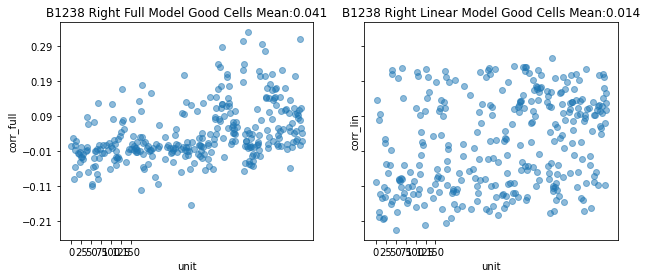

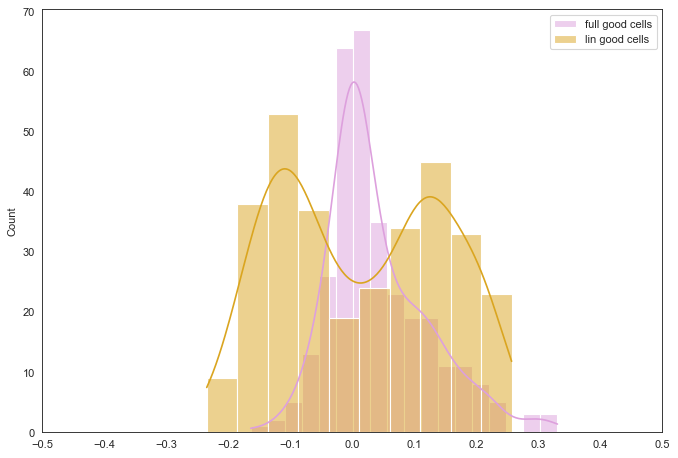

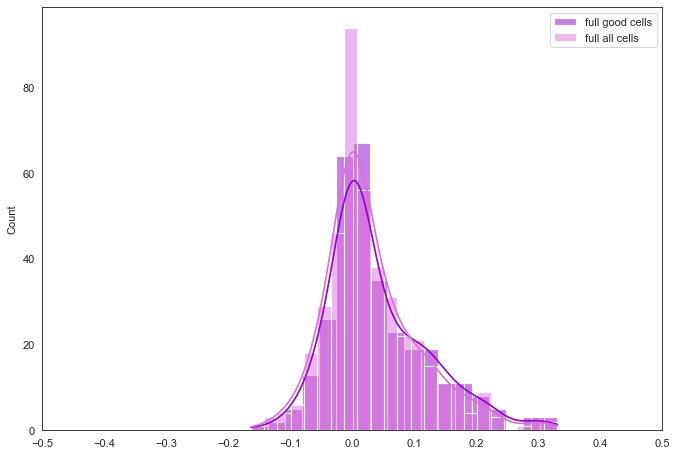

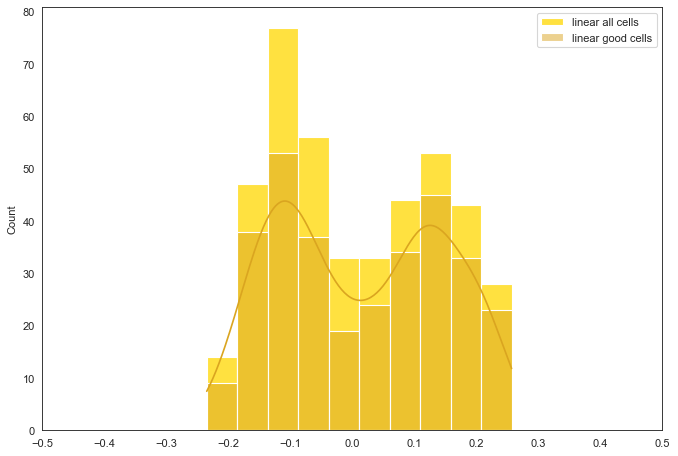

In [18]:

fig, axs = plt.subplots(1,2, figsize = (10,4), sharey=True)
# Plot
axs[0].scatter(units_good, corrs_full_good, alpha=0.5)
axs[0].set_title(f"{bird} Right Full Model Good Cells Mean:{np.round(np.nanmean(corrs_full_good),3)}")
axs[0].set_xlabel('unit')
axs[0].set_ylabel('corr_full')
axs[0].set_yticks(np.arange(-0.51,0.51, step=0.1)) 
axs[0].set_xticks(np.arange(0,175, step=25)) 
axs[1].scatter(units_good, corrs_lin_good, alpha=0.5)
axs[1].set_title(f"{bird} Right Linear Model Good Cells Mean:{np.round(np.nanmean(corrs_lin_good),3)}")
axs[1].set_xlabel('unit')
axs[1].set_ylabel('corr_lin')
axs[1].set_xticks(np.arange(0,175, step=25)) 
plt.show()

sns.set_style('white')
plt.figure(figsize=(10,7), dpi= 80)
sns.histplot(corrs_full_good, color="plum", label="full good cells", kde=True)
sns.histplot(corrs_lin_good, color="goldenrod", label="lin good cells", kde=True)
plt.xticks(np.arange(-0.5,0.51, step=0.1)) 
plt.legend();

sns.set_style('white')
plt.figure(figsize=(10,7), dpi= 80)
sns.histplot(corrs_full_good, color="darkviolet", label="full good cells", kde=True)
sns.histplot(corrs_full, color="orchid", label="full all cells", kde=True)
plt.xticks(np.arange(-0.5,0.51, step=0.1)) 
plt.legend();


sns.set_style('white')
plt.figure(figsize=(10,7), dpi= 80)
sns.histplot(corrs_lin, color="gold", label="linear all cells"                                                                                                            )
sns.histplot(corrs_lin_good, color="goldenrod", label="linear good cells", kde=True)
plt.xticks(np.arange(-0.5,0.51, step=0.1)) 
plt.legend();



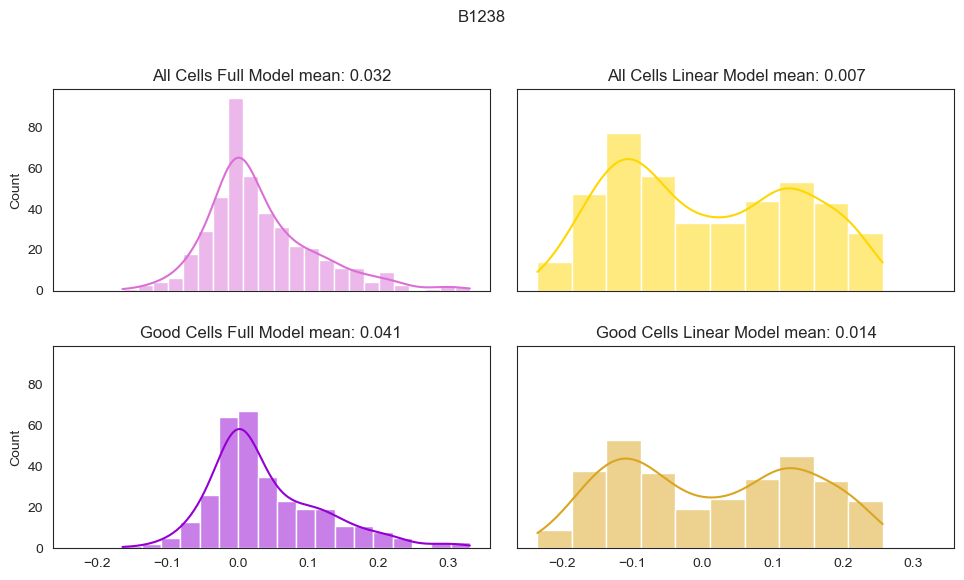

In [19]:
sns.set_style('white')
fig, axes = plt.subplots(2, 2, figsize=(10,6), sharey=True, sharex=True, dpi=100)
sns.histplot(corrs_full , color="orchid", ax=axes[0,0], kde=True).set(title=f'All Cells Full Model mean: {np.round(np.nanmean(corrs_full),3)}')
sns.histplot(corrs_lin , color="gold", ax=axes[0,1], kde=True).set(title=f'All Cells Linear Model mean: {np.round(np.nanmean(corrs_lin),3)}')
sns.histplot(corrs_full_good , color="darkviolet", ax=axes[1,0], kde=True).set(title=f'Good Cells Full Model mean: {np.round(np.nanmean(corrs_full_good),3)}')
sns.histplot(corrs_lin_good , color="goldenrod", ax=axes[1,1], kde=True).set(title=f'Good Cells Linear Model mean: {np.round(np.nanmean(corrs_lin_good),3)}')
fig.suptitle(f"{bird}")
fig.tight_layout(pad=2.0);

In [ ]:
probs_pred_good_fs, probs_pred_lin_good_fs, resps_all_good_fs, units_good_fs, corrs_full_good_fs, corrs_lin_good_fs = run_corrs(units_to_process_good, pfinals_full_shuff, stims_test_full_shuff, resps_test_full_shuff)
probs_pred_good_ms, probs_pred_lin_good_ms, resps_all_good_ms, units_good_ms, corrs_full_good_ms, corrs_lin_good_ms = run_corrs(units_to_process_good, pfinals_mask_shuff, stims_test_mask_shuff, resps_test_mask_shuff)
probs_pred_good_ps, probs_pred_lin_good_ps, resps_all_good_ps, units_good_ps, corrs_full_good_ps, corrs_lin_good_ps = run_corrs(units_to_process_good, pfinals_permute_shuff, stims_test_ps_shuff, resps_test_ps_shuff)


In [ ]:
sns.set_style('white')
fig, axes = plt.subplots(2, 2, figsize=(10,6), sharey=True, sharex=True, dpi=100)
sns.histplot(corrs_full_good , color="darkviolet", ax=axes[0,0], bins=10, kde=True).set(title=f'Good Cells Model mean: {np.round(np.nanmean(corrs_full_good),3)}')
sns.histplot(corrs_full_good_fs , color="orange", ax=axes[0,1], bins=10, kde=True).set(title=f'Good Cells Shuffle mean: {np.round(np.nanmean(corrs_full_good_fs),3)}')
sns.histplot(corrs_full_good_ps , color="green", ax=axes[1,0], bins=10, kde=True).set(title=f'Good Cells Permute Shuffle mean: {np.round(np.nanmean(corrs_full_good_ps),3)}')
sns.histplot(corrs_full_good_ms , color="red", ax=axes[1,1], bins=10, kde=True).set(title=f'Good Cells Mask Shuffle mean: {np.round(np.nanmean(corrs_full_good_ms),3)}')
axs[1].set_xticks(np.arange(-0.51,0.51, step=0.1)) 
axs[0].set_xticks(np.arange(-0.51,0.51, step=0.1)) 
fig.suptitle(f"{bird}")
fig.tight_layout(pad=2.0);

In [ ]:
sns.set_style('white')
fig, axes = plt.subplots(2, 2, figsize=(10,6), sharey=True, sharex=True, dpi=100)
sns.distplot(corrs_full_good , color="darkviolet", ax=axes[0,0]).set(title=f'Good Cells Model mean: {np.round(np.nanmean(corrs_full_good),3)}')
sns.distplot(corrs_full_good_fs , color="orange", ax=axes[0,1]).set(title=f'Good Cells Shuffle mean: {np.round(np.nanmean(corrs_full_good_fs),3)}')
sns.distplot(corrs_full_good_ps , color="green", ax=axes[1,0]).set(title=f'Good Cells Permute Shuffle mean: {np.round(np.nanmean(corrs_full_good_ps),3)}')
sns.distplot(corrs_full_good_ms , color="red", ax=axes[1,1]).set(title=f'Good Cells Mask Shuffle mean: {np.round(np.nanmean(corrs_full_good_ms),3)}')
fig.suptitle(f"{bird}")
fig.tight_layout(pad=2.0);

In [ ]:
import pandas as pd
df_corrs = pd.DataFrame(list(zip(corrs_full_good, corrs_lin_good, corrs_full_good_fs, corrs_full_good_ms, 
                                 corrs_full_good_ps)), columns = ['Full Model', "Linear Model", 'Full Shuffle',
                                'Vector Shuffle', 'All Stim Vector Shuffle'])

df_corrs.head()

fig, ax = plt.subplots(figsize=(11,10))
colors = ['darkviolet', 'pink', 'greenyellow','dodgerblue', 'powderblue', '#705898', '#98D8D8']
boxplot = sns.violinplot(ax = ax, x='variable', y="value", data=pd.melt(df_corrs), palette=colors)
boxplot.axes.set_title("Distribution of Forest Fire Conditions", fontsize=32)
boxplot.set_xlabel("", fontsize=32)
boxplot.set_ylabel("Values", fontsize=32)
plt.xticks(rotation=40)
plt.tick_params(labelsize=24)
plt.show()

In [ ]:
import pandas as pd
df_corrs = pd.DataFrame(list(zip(corrs_full_good, corrs_lin_good, corrs_full_good_fs, corrs_full_good_ms, 
                                 corrs_full_good_ps)), columns = ['Full Model', "Linear Model", 'Full Shuffle',
                                'Vector Shuffle', 'All Stim Vector Shuffle'])

df_corrs.head()


fig, ax = plt.subplots(figsize=(15,10))
colors = ['orchid', 'greenyellow', 'tomato','dodgerblue', 'powderblue']
boxplot = sns.boxplot(ax = ax, x='variable', y="value", data=pd.melt(df_corrs), palette=colors, width=0.7)
boxplot.axes.set_title("Distribution of Individual MNE Spiking Probablilty Correlations", fontsize=32)
boxplot.set_xlabel("", fontsize=32)
boxplot.set_ylabel("Values", fontsize=32)
plt.xticks(rotation=15)
boxplot.tick_params(labelsize=30)
#plt.savefig('/mnt/cube/lstanwic/reducted_data/s_b1253_21/shuffleexamples.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
medians = df_corrs.median()
print(medians)

## OLD CODE

In [ ]:
sns.set_style('white')
fig, axes = plt.subplots(1, 4, figsize=(12,3), sharey=True, sharex=True, dpi=100)
sns.distplot(corrs_full , color="orchid", ax=axes[0], axlabel=f'mean: {np.round(np.nanmean(corrs_full),3)}').set(title='full')
sns.distplot(corrs_lin , color="gold", ax=axes[1], axlabel=f'mean: {np.round(np.nanmean(corrs_lin),3)}').set(title='linear')
sns.distplot(shuff_corrs_full , color="dodgerblue", ax=axes[2], axlabel=f'mean: {np.round(np.nanmean(shuff_corrs_full),3)}').set(title='shuff full')
sns.distplot(shuff_corrs_lin , color="red", ax=axes[3], axlabel=f'mean: {np.round(np.nanmean(shuff_corrs_lin),3)}').set(title='shuff linear')
fig.suptitle(f"{bird} 6/14/21");


In [ ]:
import scipy.stats as stats
#do this later
#https://stackoverflow.com/questions/27872723/is-there-a-clean-way-to-generate-a-line-histogram-chart-in-python

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(shuff_corrs_full, color="dodgerblue", label="shuffled full", **kwargs)
sns.distplot(corrs_full, color="orchid", label="full", **kwargs)
sns.distplot(shuff_corrs_lin, color="red", label="shuffled lin", **kwargs)
sns.distplot(corrs_lin, color="gold", label="lin", **kwargs)
plt.legend();